In [10]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from skimage import color as skolor # see the docs at scikit-image.org/
from skimage import measure
from scipy.ndimage import gaussian_filter

import numpy as np
from scipy.special import binom
import matplotlib.pyplot as plt

##from https://stackoverflow.com/questions/50731785/create-random-shape-contour-using-matplotlib

bernstein = lambda n, k, t: binom(n,k)* t**k * (1.-t)**(n-k)

def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.zeros((num, 2))
    for i in range(N):
        curve += np.outer(bernstein(N - 1, i, t), points[i])
    return curve

class Segment():
    def __init__(self, p1, p2, angle1, angle2, **kw):
        self.p1 = p1; self.p2 = p2
        self.angle1 = angle1; self.angle2 = angle2
        self.numpoints = kw.get("numpoints", 100)
        r = kw.get("r", 0.3)
        d = np.sqrt(np.sum((self.p2-self.p1)**2))
        self.r = r*d
        self.p = np.zeros((4,2))
        self.p[0,:] = self.p1[:]
        self.p[3,:] = self.p2[:]
        self.calc_intermediate_points(self.r)

    def calc_intermediate_points(self,r):
        self.p[1,:] = self.p1 + np.array([self.r*np.cos(self.angle1),
                                          self.r*np.sin(self.angle1)])
        self.p[2,:] = self.p2 + np.array([self.r*np.cos(self.angle2+np.pi),
                                          self.r*np.sin(self.angle2+np.pi)])
        self.curve = bezier(self.p,self.numpoints)


def get_curve(points, **kw):
    segments = []
    for i in range(len(points)-1):
        seg = Segment(points[i,:2], points[i+1,:2], points[i,2],points[i+1,2],**kw)
        segments.append(seg)
    curve = np.concatenate([s.curve for s in segments])
    return segments, curve

def ccw_sort(p):
    d = p-np.mean(p,axis=0)
    s = np.arctan2(d[:,0], d[:,1])
    return p[np.argsort(s),:]

def get_bezier_curve(a, rad=0.2, edgy=0):
    """ given an array of points *a*, create a curve through
    those points.
    *rad* is a number between 0 and 1 to steer the distance of
          control points.
    *edgy* is a parameter which controls how "edgy" the curve is,
           edgy=0 is smoothest."""
    p = np.arctan(edgy)/np.pi+.5
    a = ccw_sort(a)
    a = np.append(a, np.atleast_2d(a[0,:]), axis=0)
    d = np.diff(a, axis=0)
    ang = np.arctan2(d[:,1],d[:,0])
    f = lambda ang : (ang>=0)*ang + (ang<0)*(ang+2*np.pi)
    ang = f(ang)
    ang1 = ang
    ang2 = np.roll(ang,1)
    ang = p*ang1 + (1-p)*ang2 + (np.abs(ang2-ang1) > np.pi )*np.pi
    ang = np.append(ang, [ang[0]])
    a = np.append(a, np.atleast_2d(ang).T, axis=1)
    s, c = get_curve(a, r=rad, method="var")
    x,y = c.T
    return x,y, a


def get_random_points(n=5, scale=0.8, mindst=None, rec=0):
    """ create n random points in the unit square, which are *mindst*
    apart, then scale them."""
    mindst = mindst or .7/n
    a = np.random.rand(n,2)
    d = np.sqrt(np.sum(np.diff(ccw_sort(a), axis=0), axis=1)**2)
    if np.all(d >= mindst) or rec>=200:
        return a*scale
    else:
        return get_random_points(n=n, scale=scale, mindst=mindst, rec=rec+1)

In [11]:
#Inspired from https://github.com/TimoFlesch/2D-Shape-Generator
import cv2
import numpy as np
import os
import skimage.exposure
from numpy.random import default_rng
import cairo
import  math
import matplotlib.pyplot as plt

#Canvas creation
def makeSurface(ssize):
    img = cairo.ImageSurface(cairo.FORMAT_ARGB32,ssize[0],ssize[1])
    return img

def makeContext(img):
    return cairo.Context(img)

def makeCanvas(imsize,bgcol):
    img = makeSurface(imsize)
    ctx = makeContext(img)
    ctx.set_source_rgb(bgcol[0],bgcol[1],bgcol[2])
    ctx.paint()
    return img,ctx


def clearContext(ctx,col):
    ctx.set_source_rgb(col[0],col[1],col[2])
    ctx.paint()
    return ctx

#Transformation
def translateShape(ctx,dx=0,dy=0):
    ctx.translate(dx,dy)
    return ctx

def rotateShape(ctx,angle):
    ctx.rotate(math.radians(angle))
    return ctx

def scaleShape(ctx,scale):
    ctx.scale(scale[0],scale[1])
    return ctx

def colouriseShape(ctx,newCol):
    ctx.set_source_rgb(newCol[0],newCol[1],newCol[2])
    return ctx

#Shapes
def drawRect(ctx,size,rectRatio):
    ctx.rectangle(0-(size/rectRatio[0])/2,0-(size/rectRatio[1])/2,size/rectRatio[0],size/rectRatio[1])
    return ctx

def drawPolygon(ctx,size,numVertices=4):
    circ = 2*math.pi
    angle = circ/numVertices
    coords = [(math.sin(angle*ii)*size,math.cos(angle*ii)*size) for ii in range(numVertices)]
    for ii in coords:
        ctx.line_to(ii[0],ii[1])
    return ctx

def drawStar(ctx,outerRadius,innerRadius,numVertices=5):
    circ = 2*math.pi
    angle = circ/(numVertices*2)
    coords = []
    for ii in range(numVertices*2):
        r = innerRadius if ii%2 else outerRadius
        coords.append([math.sin(angle*ii)*r,math.cos(angle*ii)*r])
    # coords = [[sum(translate_op) for translate_op in zip(coordPair,centre)]for coordPair in coords]

    for ii in coords:
        ctx.line_to(ii[0],ii[1])
    # ctx.close_path()
    return ctx

def drawRandom(ctx, size):
    rad = 0.2
    edgy = 0.05
    a = get_random_points(n=7, scale=size)
    x,y, _ = get_bezier_curve(a,rad=rad, edgy=edgy)
    coords = zip(x-size/2,y-size/2)

    for ii in coords:
        ctx.line_to(ii[0],ii[1])
        print(ii[0])
        print(ii[1])
    # ctx.close_path()
    return ctx

def drawRandom2(ctx, size):
    n = 8 # Number of possibly sharp edges
    r = .7 # magnitude of the perturbation from the unit circle,
    # should be between 0 and 1
    N = n*3+1 # number of points in the Path
    # There is the initial point and 3 points per cubic bezier curve. Thus, the curve will only pass though n points, which will be the sharp edges, the other 2 modify the shape of the bezier curve

    angles = np.linspace(0,2*np.pi,N)
    codes = np.full(N,Path.CURVE4)
    codes[0] = Path.MOVETO

    verts = np.stack((np.cos(angles),np.sin(angles))).T*(2*r*np.random.random(N)+1-r)[:,None]
    verts[-1,:] = verts[0,:]
    for v in verts:
        v *= size
        v += size/2
        print(v)
        ctx.line_to(v[0], v[1])

    return ctx


def drawCircle(ctx,size):
    ctx.arc(0,0,size,0,math.pi*2)
    return ctx

def drawEllipse(ctx,centre,size,scale):
    ctx.scale(scale[0],scale[1])
    ctx = drawCircle(ctx,[0,0],size)
    ctx.scale(1,1)
    ctx.translate(0,centre[1])
    return ctx



# General image operations
# https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

def image_fill(image, width, height, color):
    #255 = blank 0 = black
    bg = np.zeros([width, height], np.uint8)
    bg[:,:] = 255
    h1, w1 = image.shape
    yoff = round((height-h1)/2)
    xoff = round((width-w1)/2)
    result = bg.copy()
    result[yoff:yoff+h1, xoff:xoff+w1] = image
    return result

def random_shapes(w, h):
    seedval = 1
    rng = default_rng(seed=seedval)

    # define image size
    width=w
    height=h

    # create random noise image
    noise = rng.integers(0, 255, (height,width), np.uint8, True)

    # blur the noise image to control the size
    blur = cv2.GaussianBlur(noise, (127,127), sigmaX=30, sigmaY=30, borderType = cv2.BORDER_DEFAULT)

    # stretch the blurred image to full dynamic range
    stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0,255)).astype(np.uint8)

    # threshold stretched image to control the size
    thresh = cv2.threshold(stretch, 175, 255, cv2.THRESH_BINARY)[1]

    # apply morphology open and close to smooth out shapes
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    result = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel)

    return result

In [12]:
class Properties:
    trX = 32
    trY = 64
    rota = 90
    scale = [1,1]
    mask_color = [0.,0.,0.]

    size = 4
    #rect
    rect_ratio = [1, 1]

    # poly
    vertices = 5

    #star
    size2 = 10
    branch = 10

    #circle

    #elipse
    ellipse_ratio = [.2, 1.]

prop = Properties()


def prepare(ctx, ctr, p):
    ctx = translateShape(ctx,ctr[0],ctr[1])
    ctx = translateShape(ctx,p.trX,p.trY)
    ctx = rotateShape(ctx, p.rota)
    ctx = scaleShape(ctx, p.scale)
    ctx = colouriseShape(ctx,p.mask_color)
    return ctx

def rectangle(ctx, ctr, size, ratio, p):
    prepare(ctx, ctr, p)
    ctx = drawRect(ctx, size, ratio)
    ctx.fill()
    return ctx

def poly(ctx, ctr, size, numVertices, p):
    prepare(ctx, ctr, p)
    ctx = drawPolygon(ctx, size, numVertices)
    ctx.fill()
    return ctx

def star(ctx, ctr, size, size2, branch, p):
    prepare(ctx, ctr, p)
    ctx = drawStar(ctx, size,size2, numVertices= branch)
    ctx.fill()
    return ctx

def circle(ctx, ctr, size, p):
    prepare(ctx, ctr, p)
    ctx = drawCircle(ctx, ctr)
    ctx.fill()
    return ctx

def ellipse(ctx, ctr, size, ratio, p):
    prepare(ctx, ctr, p)
    ctx = drawEllipse(ctx, ctr, size, ratio)
    ctx.fill()
    return ctx

def random_shape(ctx, ctr, size, p):
    prepare(ctx, (ctr[0], ctr[1]), p)
    ctx = drawRandom(ctx, size)
    ctx.fill()
    return ctx
def random_shape2(ctx, ctr, size, p):
    prepare(ctx, (ctr[0], ctr[1]), p)
    ctx = drawRandom2(ctx, size)
    ctx.fill()
    return ctx

In [13]:
def create_mask(w,h,p):
    img,ctx = makeCanvas((w, h), [255,255,255])

    p.trX = w/2
    p.trY = h/4
    p.size = 64
    img_centre = np.floor(img.get_width()/2), np.floor(img.get_height()/2)
    ctx.save()

    #ctx = rectangle(ctx, ctr_inv, size, rect_ratio)
    #ctx = ellipse(ctx, ctr_inv, size, ellipse_ratio)
    #ctx = poly(ctx, [0,0], p.size, 10, p)
    ctx = random_shape2(ctx, [0,0], p.size, p)
    #ctx= rectangle(ctx, [0,0], p.size, [1,2], p)
    tmp = np.frombuffer(img.get_data(),np.uint8)
    tmp.shape = [w,h,4]
    tmp = tmp[:,:,0:3]
    cv2.imwrite("test2.jpg", tmp)
    img.write_to_png('img_' + 'test' + '.png')
    ctx.restore()
    ctx = clearContext(ctx, [255,255,255])
    return tmp

mask = create_mask(128,128, Properties())

[107.2006883  32.       ]
[61.60541397 39.93274676]
[98.98665852 70.67476533]
[108.46239114 108.46239114]
[60.2343562  80.90333946]
[ 57.90690033 128.68586828]
[ 32.         121.23232444]
[ 13.54712721 100.86705879]
[ 8.54554307 72.62431107]
[-16.19508081  80.19508081]
[-17.31227091  60.47045289]
[-71.92823191  59.84748581]
[-23.65682051  32.        ]
[-5.77960466 21.87698544]
[-56.06330942 -18.8433754 ]
[-8.75386581 -8.75386581]
[ -5.29583318 -32.59827798]
[  6.00316931 -65.02149297]
[32.          1.37370551]
[ 48.21271391 -28.50667203]
[ 59.0967841  -14.93300679]
[ 79.35516303 -15.35516303]
[119.75004365 -18.66251132]
[92.96696293 15.66395152]
[107.2006883  32.       ]


In [14]:
print(mask.shape)
cv2.imwrite("test.jpg", mask)

(128, 128, 3)


True

In [15]:
file = r"./car.jpg"
img = cv2.imread(file , 0)
print(img.shape)
img_resize = image_resize(img, 128, 128)
img_re2 = image_fill(img_resize, 128, 128, 255)

AttributeError: 'NoneType' object has no attribute 'shape'

In [16]:
cv2.imwrite("./car2.jpg", img_resize)
cv2.imwrite("./car3.jpg", img_re2)
cv2.imwrite("./random.jpg", random_shapes(128,128))

NameError: name 'img_resize' is not defined

In [17]:
# read the input image
img = cv2.imread("car.jpg")
# convert from BGR to RGB so we can plot using matplotlib
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# disable x & y axis
plt.axis('off')
# show the image
plt.imshow(img)
plt.show()
# get the image shape
rows, cols, dim = img.shape

for i in range(1):
    translated_img = cv2.resize(img, (128, 128))
    img = cv2.resize(translated_img, (cols,rows))
plt.axis('off')
# show the resulting image
plt.imshow(translated_img)
plt.show()
# apply a perspective transformation to the image
translated_img = cv2.resize(img, (128, 128))
# disable x & y axis
plt.axis('off')
# show the resulting image
plt.imshow(img)
plt.show()
# save the resulting image to disk
plt.imsave("car_translated.jpg", translated_img)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


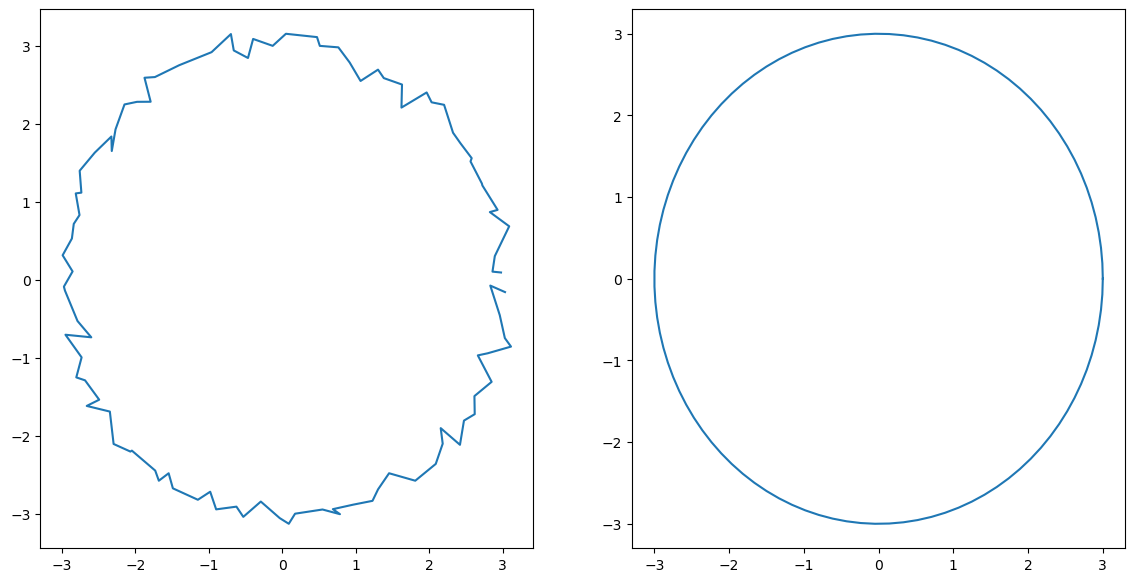

In [18]:
fig, (bumpy, smooth) = plt.subplots(ncols=2, figsize=(14, 7))

an = np.linspace(0, 2 * np.pi, 100)

bumpy.plot(3 * np.cos(an) + np.random.normal(0,.1,100), 3 * np.sin(an) + np.random.normal(0,.1,100))

smooth.plot(3 * np.cos(an), 3 * np.sin(an))

In [19]:
import shutil
import os
import numpy as np

def get_files_from_folder(path):
    files = os.listdir(path)
    print(files)
    return np.asarray(files)

def split(path_to_data, path_to_test_data, train_ratio):
    # get dirs
    _, dirs, _ = next(os.walk(path_to_data))


    # calculates how many train data per class
    data_counter_per_class = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(path_to_data, dirs[i])
        files = get_files_from_folder(path)
        data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - train_ratio))
    print(test_counter)

    # transfers files
    for i in range(len(dirs)):
        path_to_original = os.path.join(path_to_data, dirs[i])
        path_to_save = os.path.join(path_to_test_data, dirs[i])

        #creates dir
        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)
        files = get_files_from_folder(path_to_original)
        # moves data
        for j in range(int(test_counter[i])):
            dst = os.path.join(path_to_save, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.move(src, dst)


split('../small_for_test/', '../test', float(0.7))

['00000001_0002_00000000.jpg', '00000001_0002_00000001.jpg', '00000001_0002_00000002.jpg', '00000001_0002_00000003.jpg', '00000001_0002_00000004.jpg', '00000002_0001_00000000.jpg', '00000002_0001_00000001.jpg', '00000002_0001_00000002.jpg', '00000002_0001_00000003.jpg', '00000002_0002_00000000.jpg', '00000002_0002_00000001.jpg', '00000002_0002_00000002.jpg', '00000002_0002_00000003.jpg', '00000002_0002_00000004.jpg', '00000003_0001_00000000.jpg', '00000003_0001_00000001.jpg', '00000003_0001_00000002.jpg', '00000003_0001_00000003.jpg', '00000003_0001_00000004.jpg', '00000003_0002_00000000.jpg', '00000003_0002_00000001.jpg', '00000003_0002_00000002.jpg', '00000003_0002_00000003.jpg', '00000003_0002_00000004.jpg', '00000009_0001_00000000.jpg', '00000009_0001_00000001.jpg', '00000009_0001_00000002.jpg', '00000009_0001_00000003.jpg', '00000009_0001_00000004.jpg', '00000009_0002_00000000.jpg', '00000009_0002_00000001.jpg', '00000009_0002_00000002.jpg', '00000009_0002_00000003.jpg', '00000009

In [20]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from skimage import color as skolor # see the docs at scikit-image.org/
from skimage import measure
from scipy.ndimage import gaussian_filter

import numpy as np
from scipy.special import binom
import matplotlib.pyplot as plt


bernstein = lambda n, k, t: binom(n,k)* t**k * (1.-t)**(n-k)

def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.zeros((num, 2))
    for i in range(N):
        curve += np.outer(bernstein(N - 1, i, t), points[i])
    return curve

class Segment():
    def __init__(self, p1, p2, angle1, angle2, **kw):
        self.p1 = p1; self.p2 = p2
        self.angle1 = angle1; self.angle2 = angle2
        self.numpoints = kw.get("numpoints", 100)
        r = kw.get("r", 0.3)
        d = np.sqrt(np.sum((self.p2-self.p1)**2))
        self.r = r*d
        self.p = np.zeros((4,2))
        self.p[0,:] = self.p1[:]
        self.p[3,:] = self.p2[:]
        self.calc_intermediate_points(self.r)

    def calc_intermediate_points(self,r):
        self.p[1,:] = self.p1 + np.array([self.r*np.cos(self.angle1),
                                          self.r*np.sin(self.angle1)])
        self.p[2,:] = self.p2 + np.array([self.r*np.cos(self.angle2+np.pi),
                                          self.r*np.sin(self.angle2+np.pi)])
        self.curve = bezier(self.p,self.numpoints)


def get_curve(points, **kw):
    segments = []
    for i in range(len(points)-1):
        seg = Segment(points[i,:2], points[i+1,:2], points[i,2],points[i+1,2],**kw)
        segments.append(seg)
    curve = np.concatenate([s.curve for s in segments])
    return segments, curve

def ccw_sort(p):
    d = p-np.mean(p,axis=0)
    s = np.arctan2(d[:,0], d[:,1])
    return p[np.argsort(s),:]

def get_bezier_curve(a, rad=0.2, edgy=0):
    """ given an array of points *a*, create a curve through
    those points.
    *rad* is a number between 0 and 1 to steer the distance of
          control points.
    *edgy* is a parameter which controls how "edgy" the curve is,
           edgy=0 is smoothest."""
    p = np.arctan(edgy)/np.pi+.5
    a = ccw_sort(a)
    a = np.append(a, np.atleast_2d(a[0,:]), axis=0)
    d = np.diff(a, axis=0)
    ang = np.arctan2(d[:,1],d[:,0])
    f = lambda ang : (ang>=0)*ang + (ang<0)*(ang+2*np.pi)
    ang = f(ang)
    ang1 = ang
    ang2 = np.roll(ang,1)
    ang = p*ang1 + (1-p)*ang2 + (np.abs(ang2-ang1) > np.pi )*np.pi
    ang = np.append(ang, [ang[0]])
    a = np.append(a, np.atleast_2d(ang).T, axis=1)
    s, c = get_curve(a, r=rad, method="var")
    x,y = c.T
    return x,y, a


def get_random_points(n=5, scale=0.8, mindst=None, rec=0):
    """ create n random points in the unit square, which are *mindst*
    apart, then scale them."""
    mindst = mindst or .7/n
    a = np.random.rand(n,2)
    d = np.sqrt(np.sum(np.diff(ccw_sort(a), axis=0), axis=1)**2)
    if np.all(d >= mindst) or rec>=200:
        return a*scale
    else:
        return get_random_points(n=n, scale=scale, mindst=mindst, rec=rec+1)

In [2]:
fig, ax = plt.subplots()
ax.set_aspect("equal")

rad = 0.2
edgy = 0.05

for c in np.array([[0,0]]):

    a = get_random_points(n=7, scale=2) + c
    x,y, _ = get_bezier_curve(a,rad=rad, edgy=edgy)
    plt.plot(x,y)
    print(x)

plt.show()

NameError: name 'plt' is not defined

[[ 5.35010187e-01  0.00000000e+00]
 [ 7.08823988e-01  1.89928815e-01]
 [ 1.29959653e+00  7.50322404e-01]
 [ 3.73246117e-01  3.73246117e-01]
 [ 4.09766953e-01  7.09737181e-01]
 [ 3.25521385e-01  1.21486235e+00]
 [ 8.76503604e-17  1.43143901e+00]
 [-1.40727439e-01  5.25201953e-01]
 [-1.90949623e-01  3.30734449e-01]
 [-1.05918987e+00  1.05918987e+00]
 [-9.35137217e-01  5.39901724e-01]
 [-3.34699557e-01  8.96824760e-02]
 [-1.11682403e+00  1.36771498e-16]
 [-8.20426840e-01 -2.19832709e-01]
 [-1.32014784e+00 -7.62187710e-01]
 [-7.25159431e-01 -7.25159431e-01]
 [-4.49026916e-01 -7.77737432e-01]
 [-3.07440288e-01 -1.14738278e+00]
 [-1.90075280e-16 -1.03472163e+00]
 [ 2.03321783e-01 -7.58807224e-01]
 [ 3.13488776e-01 -5.42978488e-01]
 [ 6.60023425e-01 -6.60023425e-01]
 [ 4.91955913e-01 -2.84030879e-01]
 [ 1.27851753e+00 -3.42577739e-01]
 [ 8.41937436e-01 -2.06215197e-16]]
[[ 5.35010187e-01  0.00000000e+00]
 [ 7.08823988e-01  1.89928815e-01]
 [ 1.29959653e+00  7.50322404e-01]
 [ 3.73246117e-01  

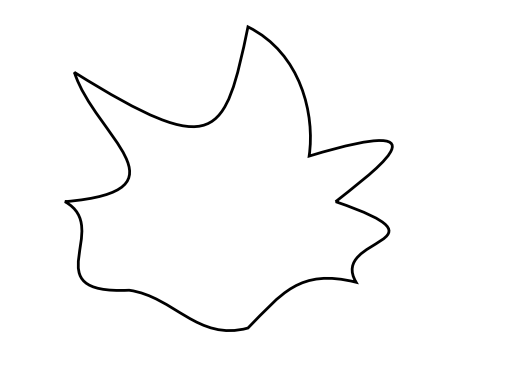

In [59]:
n = 8 # Number of possibly sharp edges
r = .7 # magnitude of the perturbation from the unit circle,
# should be between 0 and 1
N = n*3+1 # number of points in the Path
# There is the initial point and 3 points per cubic bezier curve. Thus, the curve will only pass though n points, which will be the sharp edges, the other 2 modify the shape of the bezier curve

angles = np.linspace(0,2*np.pi,N)
codes = np.full(N,Path.CURVE4)
codes[0] = Path.MOVETO

verts = np.stack((np.cos(angles),np.sin(angles))).T*(2*r*np.random.random(N)+1-r)[:,None]
print(verts)
verts[-1,:] = verts[0,:] # Using this instad of Path.CLOSEPOLY avoids an innecessary straight line
path = Path(verts, codes)
print(path.vertices)




fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(path, facecolor='none', lw=2)
ax.add_patch(patch)

ax.set_xlim(np.min(verts)*1.1, np.max(verts)*1.1)
ax.set_ylim(np.min(verts)*1.1, np.max(verts)*1.1)
ax.axis('off') # removes the axis to leave only the shape

plt.show()

In [2]:
%run main.py -in ../small_for_test/car -tro ../train -teo ../test -hr 0.5 --star 100  --bgcol 0 0 0 --maskcol 255 255 255 --resize True

 - Start the creation of the dataset - 

     With the following parameters: 
{'bgcol': [0.0, 0.0, 0.0],
 'circle': 1,
 'data_path': ['../small_for_test/car'],
 'ellipse': 1,
 'hidden_ratio': 0.5,
 'maskcol': [255.0, 255.0, 255.0],
 'poly': 1,
 'random': 1,
 'rec': 1,
 'resize': True,
 'size': [128, 128],
 'star': 100,
 'test_data_output': ['../test'],
 'train_data_output': ['../train'],
 'train_ratio': 0.7}


--Processing 24 images--

The dataset was successfully created!
The train dataset is at location: 
C:\Users\xagao\OneDrive\Bureau\TB clean\Bachelor-Thesis-De-occlusion-of-occluded-vehicle-images-from-drone-video\Dataset_creation\train
The test dataset is at location: 
C:\Users\xagao\OneDrive\Bureau\TB clean\Bachelor-Thesis-De-occlusion-of-occluded-vehicle-images-from-drone-video\Dataset_creation\test
 - Start the creation of the dataset - 

     With the following parameters: 
{'bgcol': [0.0, 0.0, 0.0],
 'circle': 1,
 'data_path': ['../small_for_test/car'],
 'ellipse': 1,
 'hidde

In [27]:
#'../small_for_test/car','../train', '../test', float(0.7)